/Users/helena/Desktop/ieor174/final_project/ieor174/lib/python3.10/site-packages/geopandas/array.py:334: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  self.crs = crs
/Users/helena/Desktop/ieor174/final_project/ieor174/lib/python3.10/site-packages/geopandas/geodataframe.py:409: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  level.crs = crs


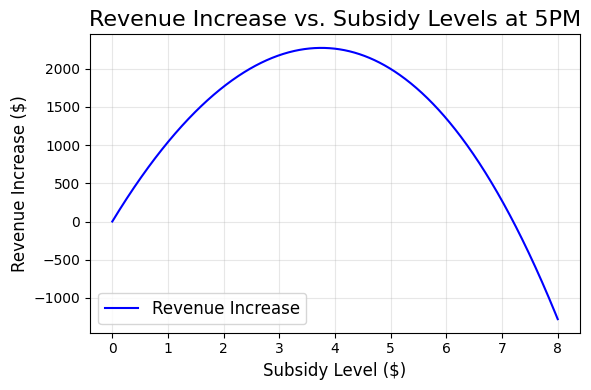

The subsidy level that produces the maximum revenue increase is $3.75
The maximum revenue increase is $2272.12


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from utilities import UberAll, UberBartMix, Drive

# Load the GeoJSON data
neighborhoods = gpd.read_file("Demographics_By_Census_Tract.geojson")

# Preprocessing
latitude_miles_per_degree = 69
longitude_miles_per_degree = 55.2
berryessa_station = Point(-121.8746, 37.3684)  # Berryessa coordinates (lon, lat)
neighborhoods['centroid'] = neighborhoods.geometry.centroid
neighborhoods['distance_to_berryessa_deg'] = neighborhoods['centroid'].distance(berryessa_station)
neighborhoods['distance_to_berryessa_miles'] = neighborhoods['distance_to_berryessa_deg'] * (
    latitude_miles_per_degree**2 + longitude_miles_per_degree**2)**0.5
neighborhoods['population'] = neighborhoods['POPTOTAL'] if 'POPTOTAL' in neighborhoods else 1000

# Constants for calculations
subsidy_levels = np.arange(0, 8.01, 0.01)  # Subsidy from 0 to 8 with step 0.01
revenue_increases = []
total_rides_no_sub = 30251
time_to_money_conversion = 25
car_pc = 0.5
safety_cost = 20
hour_of_day = 17
inconvenience_fee = 30
is_weekday = True
beta = 0.3
total_population = neighborhoods['population'].sum()

# Initialize transportation cost objects
ua = UberAll(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'])
ub = UberBartMix(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'], safety_cost)
neighborhoods['cost_uber_all'] = ua.get_cost(hour_of_day, is_weekday)
# neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
neighborhoods['cost_bart_uber_no_subsidy'] = ub.get_cost() 
neighborhoods['cost_drive'] = Drive(time_to_money_conversion, inconvenience_fee).get_cost(hour_of_day, is_weekday)

beta = 0.3 # emperically chosen it produces a reasonable logistic function
exp_bart_uber_no_subsidy = np.exp(-beta * neighborhoods['cost_bart_uber_no_subsidy'])
exp_uber_all = np.exp(-beta * neighborhoods['cost_uber_all'])
# for people without car

total_exp_without_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all

# for people with car
exp_drive = np.exp(-beta * neighborhoods['cost_drive'])
total_exp_with_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all + exp_drive

# neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) 
neighborhoods['percent_choosing_bart_no_subsidy'] = (exp_bart_uber_no_subsidy / total_exp_without_car_nosub) * (1-car_pc) + (exp_bart_uber_no_subsidy / total_exp_with_car_nosub) * car_pc


average_percent_without_subsidy = (
    (neighborhoods['percent_choosing_bart_no_subsidy'] * neighborhoods['population']).sum()
    / total_population * 100
)

# Subsidy sweep
for subsidy in subsidy_levels:

    neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
    exp_bart_uber_mix = np.exp(-beta * neighborhoods['cost_bart_uber'])
    total_exp_without_car = exp_bart_uber_mix + exp_uber_all
    total_exp_with_car = exp_bart_uber_mix + exp_uber_all + exp_drive
    neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) * (1 - car_pc) + (exp_bart_uber_mix / total_exp_with_car) * car_pc
    average_percent_with_subsidy = (
        (neighborhoods['percent_choosing_bart'] * neighborhoods['population']).sum()
        / total_population * 100
    )
    total_rides = total_rides_no_sub * (1 + average_percent_with_subsidy / 100 - average_percent_without_subsidy / 100)
    increased_ridership = total_rides - total_rides_no_sub
    increased_revenue = (7.2 - subsidy) * increased_ridership
    revenue_increases.append(increased_revenue)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(subsidy_levels, revenue_increases, label="Revenue Increase", color="blue")
plt.title("Revenue Increase vs. Subsidy Levels at 5PM", fontsize=16)
plt.xlabel("Subsidy Level ($)", fontsize=12)
plt.ylabel("Revenue Increase ($)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()
max_revenue_increase = max(revenue_increases)
optimal_subsidy = subsidy_levels[np.argmax(revenue_increases)]

# Print the results
print(f"The subsidy level that produces the maximum revenue increase is ${optimal_subsidy:.2f}")
print(f"The maximum revenue increase is ${max_revenue_increase:.2f}")

/Users/helena/Desktop/ieor174/final_project/ieor174/lib/python3.10/site-packages/geopandas/array.py:334: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  self.crs = crs
/Users/helena/Desktop/ieor174/final_project/ieor174/lib/python3.10/site-packages/geopandas/geodataframe.py:409: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  level.crs = crs


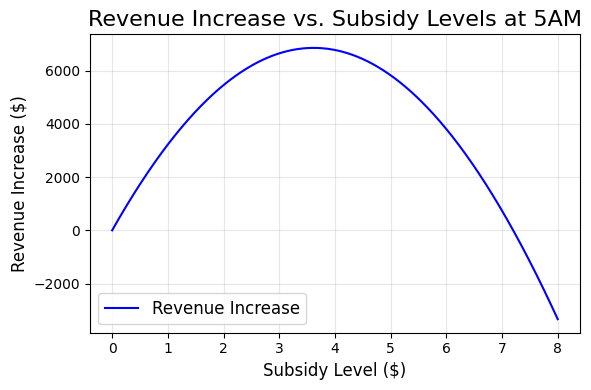

The subsidy level that produces the maximum revenue increase is $3.62
The maximum revenue increase is $6849.51


In [ ]:
hour_of_day = 5

# Load the GeoJSON data
neighborhoods = gpd.read_file("Demographics_By_Census_Tract.geojson")

# Preprocessing
latitude_miles_per_degree = 69
longitude_miles_per_degree = 55.2
berryessa_station = Point(-121.8746, 37.3684)  # Berryessa coordinates (lon, lat)
neighborhoods['centroid'] = neighborhoods.geometry.centroid
neighborhoods['distance_to_berryessa_deg'] = neighborhoods['centroid'].distance(berryessa_station)
neighborhoods['distance_to_berryessa_miles'] = neighborhoods['distance_to_berryessa_deg'] * (
    latitude_miles_per_degree**2 + longitude_miles_per_degree**2)**0.5
neighborhoods['population'] = neighborhoods['POPTOTAL'] if 'POPTOTAL' in neighborhoods else 1000

# Constants for calculations
subsidy_levels = np.arange(0, 8.01, 0.01)  # Subsidy from 0 to 8 with step 0.01
revenue_increases = []
total_rides_no_sub = 30251
time_to_money_conversion = 25
car_pc = 0.5
safety_cost = 20

inconvenience_fee = 30
is_weekday = True
beta = 0.3
total_population = neighborhoods['population'].sum()

# Initialize transportation cost objects
ua = UberAll(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'])
ub = UberBartMix(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'], safety_cost)
neighborhoods['cost_uber_all'] = ua.get_cost(hour_of_day, is_weekday)
# neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
neighborhoods['cost_bart_uber_no_subsidy'] = ub.get_cost() 
neighborhoods['cost_drive'] = Drive(time_to_money_conversion, inconvenience_fee, neighborhoods['distance_to_berryessa_miles']).get_cost(hour_of_day, is_weekday)

beta = 0.3 # emperically chosen it produces a reasonable logistic function
exp_bart_uber_no_subsidy = np.exp(-beta * neighborhoods['cost_bart_uber_no_subsidy'])
exp_uber_all = np.exp(-beta * neighborhoods['cost_uber_all'])
# for people without car

total_exp_without_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all

# for people with car
exp_drive = np.exp(-beta * neighborhoods['cost_drive'])
total_exp_with_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all + exp_drive

# neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) 
neighborhoods['percent_choosing_bart_no_subsidy'] = (exp_bart_uber_no_subsidy / total_exp_without_car_nosub) * (1-car_pc) + (exp_bart_uber_no_subsidy / total_exp_with_car_nosub) * car_pc


average_percent_without_subsidy = (
    (neighborhoods['percent_choosing_bart_no_subsidy'] * neighborhoods['population']).sum()
    / total_population * 100
)

# Subsidy sweep
for subsidy in subsidy_levels:

    neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
    exp_bart_uber_mix = np.exp(-beta * neighborhoods['cost_bart_uber'])
    total_exp_without_car = exp_bart_uber_mix + exp_uber_all
    total_exp_with_car = exp_bart_uber_mix + exp_uber_all + exp_drive
    neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) * (1 - car_pc) + (exp_bart_uber_mix / total_exp_with_car) * car_pc
    average_percent_with_subsidy = (
        (neighborhoods['percent_choosing_bart'] * neighborhoods['population']).sum()
        / total_population * 100
    )
    total_rides = total_rides_no_sub * (1 + average_percent_with_subsidy / 100 - average_percent_without_subsidy / 100)
    increased_ridership = total_rides - total_rides_no_sub
    increased_revenue = (7.2 - subsidy) * increased_ridership
    revenue_increases.append(increased_revenue)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(subsidy_levels, revenue_increases, label="Revenue Increase", color="blue")
plt.title("Revenue Increase vs. Subsidy Levels at 5AM", fontsize=16)
plt.xlabel("Subsidy Level ($)", fontsize=12)
plt.ylabel("Revenue Increase ($)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()
max_revenue_increase = max(revenue_increases)
optimal_subsidy = subsidy_levels[np.argmax(revenue_increases)]

# Print the results
print(f"The subsidy level that produces the maximum revenue increase is ${optimal_subsidy:.2f}")
print(f"The maximum revenue increase is ${max_revenue_increase:.2f}")

6.414358354770207 2.8125504849114704
1089.5828987109635
21.21445544101494 14.294349752074687
2093.401171961319
32.53784588447626 26.12913035824192
1938.700533841151
37.36126788486266 32.21968356583065
1555.3806723503767
37.848628888878686 32.87947870973285
1503.2176206934055
35.58560184960308 29.878510378186313
1726.4522410182872
31.578384294621753 25.01163430434274
1986.5075395593012
27.89493990736108 20.945248440885972
2102.3511655233924
27.5768538653476 20.60972065638422
2107.6274670435123
33.50933931343529 27.288131202635967
1881.9776655979076
40.767157723995375 36.9321879324063
1160.1167116536053
44.969007694804695 42.52031835260405
740.7530129091137
46.842436165460356 44.506004847071225
706.7938381258937
46.30623511427519 44.0137343928421
693.5043932407207
43.82668976686272 41.22858633981496
785.9522677162167
38.066070354958285 33.20833548902237
1469.5133742942708
22.927607252530983 15.933079231301903
2115.914671702012


/Users/helena/Desktop/ieor174/final_project/ieor174/lib/python3.10/site-packages/geopandas/array.py:334: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  self.crs = crs
/Users/helena/Desktop/ieor174/final_project/ieor174/lib/python3.10/site-packages/geopandas/geodataframe.py:409: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  level.crs = crs


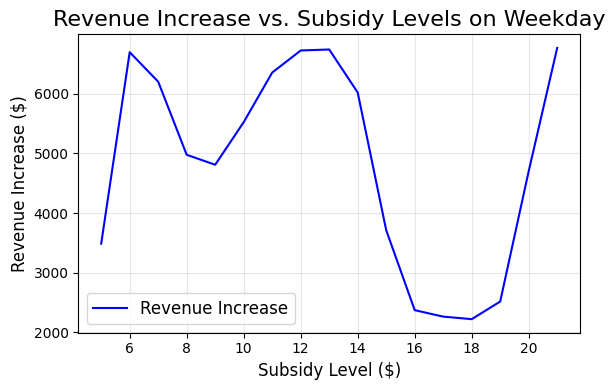

[np.float64(3486.6652758750834), np.float64(6698.883750276222), np.float64(6203.841708291683), np.float64(4977.218151521206), np.float64(4810.296386218898), np.float64(5524.647171258519), np.float64(6356.824126589764), np.float64(6727.523729674856), np.float64(6744.407894539239), np.float64(6022.328529913305), np.float64(3712.3734772915373), np.float64(2370.4096413091643), np.float64(2261.7402820028597), np.float64(2219.2140583703062), np.float64(2515.047256691894), np.float64(4702.442797741666), np.float64(6770.926949446439)]
The best hour is 21.00
The maximum revenue increase is $6770.93


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from utilities import UberAll, UberBartMix, Drive

# Load the GeoJSON data
neighborhoods = gpd.read_file("Demographics_By_Census_Tract.geojson")

# Preprocessing
latitude_miles_per_degree = 69
longitude_miles_per_degree = 55.2
berryessa_station = Point(-121.8746, 37.3684)  # Berryessa coordinates (lon, lat)
neighborhoods['centroid'] = neighborhoods.geometry.centroid
neighborhoods['distance_to_berryessa_deg'] = neighborhoods['centroid'].distance(berryessa_station)
neighborhoods['distance_to_berryessa_miles'] = neighborhoods['distance_to_berryessa_deg'] * (latitude_miles_per_degree**2 + longitude_miles_per_degree**2)**0.5
neighborhoods['population'] = neighborhoods['POPTOTAL'] if 'POPTOTAL' in neighborhoods else 1000

# Constants for calculations
subsidy = 4  # Subsidy from 0 to 8 with step 0.01
revenue_increases = []
total_rides_no_sub = 30251
time_to_money_conversion = 25
car_pc = 0.5
safety_cost = 20
hours_of_day = np.arange(5, 21.1, 1)
inconvenience_fee = 30
is_weekday = True
beta = 0.3
total_population = neighborhoods['population'].sum()
# hours sweep
for hour_of_day in hours_of_day:
    ua = UberAll(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'])
    ub = UberBartMix(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'], safety_cost)
    neighborhoods['cost_uber_all'] = ua.get_cost(hour_of_day, is_weekday)
    # neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
    neighborhoods['cost_bart_uber_no_subsidy'] = ub.get_cost() 
    neighborhoods['cost_drive'] = Drive(time_to_money_conversion, inconvenience_fee, neighborhoods['distance_to_berryessa_miles']).get_cost(hour_of_day, is_weekday)

    beta = 0.3 # emperically chosen it produces a reasonable logistic function
    exp_bart_uber_no_subsidy = np.exp(-beta * neighborhoods['cost_bart_uber_no_subsidy'])
    exp_uber_all = np.exp(-beta * neighborhoods['cost_uber_all'])
    exp_drive = np.exp(-beta * neighborhoods['cost_drive'])

    # neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) 


    
    subsidy = 4
    neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
    exp_bart_uber_mix = np.exp(-beta * neighborhoods['cost_bart_uber'])
    total_exp_without_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all
    total_exp_with_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all + exp_drive
    total_exp_without_car = exp_bart_uber_mix + exp_uber_all
    total_exp_with_car = exp_bart_uber_mix + exp_uber_all + exp_drive
    neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) * (1 - car_pc) + (exp_bart_uber_mix / total_exp_with_car) * car_pc
    neighborhoods['percent_choosing_bart_no_subsidy'] = (exp_bart_uber_no_subsidy / total_exp_without_car_nosub) * (1-car_pc) + (exp_bart_uber_no_subsidy / total_exp_with_car_nosub) * car_pc
    average_percent_without_subsidy = (
            (neighborhoods['percent_choosing_bart_no_subsidy'] * neighborhoods['population']).sum()
            / total_population * 100
        )
    average_percent_with_subsidy = (
        (neighborhoods['percent_choosing_bart'] * neighborhoods['population']).sum()
        / total_population * 100
    )
    total_rides = total_rides_no_sub * (1 + average_percent_with_subsidy / 100 - average_percent_without_subsidy / 100)

    increased_ridership = total_rides - total_rides_no_sub
    increased_revenue = (7.2 - subsidy) * increased_ridership
    print(average_percent_with_subsidy, average_percent_without_subsidy)
    print(increased_ridership)
    revenue_increases.append(increased_revenue)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(hours_of_day, revenue_increases, label="Revenue Increase", color="blue")
plt.title("Revenue Increase vs. Subsidy Levels on Weekday", fontsize=16)
plt.xlabel("Subsidy Level ($)", fontsize=12)
plt.ylabel("Revenue Increase ($)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()
max_revenue_increase = max(revenue_increases)
optimal_subsidy = hours_of_day[np.argmax(revenue_increases)]
print(revenue_increases)
# Print the results
print(f"The best hour is {optimal_subsidy:.2f}")
print(f"The maximum revenue increase is ${max_revenue_increase:.2f}")

13.927715125269607 7.997076986401535
1794.0773433889808
14.893212258755288 8.772046287292659
1851.7139180271552
15.806757890506859 9.523625360340764
1900.7104217005399
16.983714828288292 10.516834155174786
1956.2960724235636
18.044230624232892 11.434809724124259
1999.4159164918674
18.624840891101094 11.945959776974423
2020.4283258344658
19.093786286481716 12.362949679798405
2036.1453818877708
19.8270614856176 13.023472514281998
2058.153699718736
21.204612701111433 14.291953157170692
2091.148638637511
24.367892489971325 17.33722466028532
2126.84732515832
29.00083750631127 22.146800389130227
2073.4147683184456
33.24204161377233 27.001553020981618
1887.8102042051178
35.81370805838981 30.22511963680234
1690.6038834144274
36.28787849063399 30.84952215903155
1645.15717387306
34.923011679467145 29.0904012061947
1764.4229942696438
31.730909606705815 25.22531202273632
1968.0083251266115
26.662157130952814 19.67486090962411
2113.726979914143


/Users/helena/Desktop/ieor174/final_project/ieor174/lib/python3.10/site-packages/geopandas/array.py:334: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  self.crs = crs
/Users/helena/Desktop/ieor174/final_project/ieor174/lib/python3.10/site-packages/geopandas/geodataframe.py:409: UserWarning: Cannot set the CRS, falling back to None. The CRS support requires the 'pyproj' package, but it is not installed or does not import correctly. The functions depending on CRS will raise an error or may produce unexpected results.
  level.crs = crs


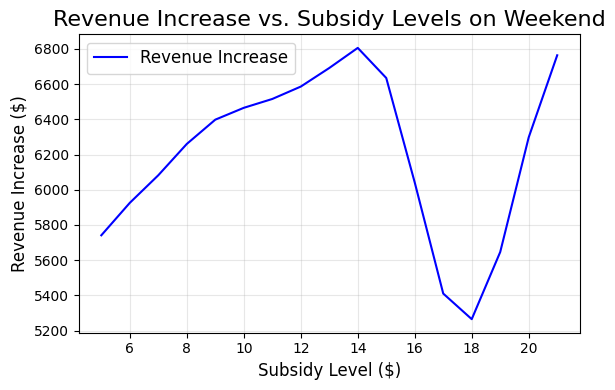

[np.float64(5741.047498844739), np.float64(5925.484537686897), np.float64(6082.273349441728), np.float64(6260.147431755404), np.float64(6398.130932773976), np.float64(6465.370642670291), np.float64(6515.665222040867), np.float64(6586.091839099955), np.float64(6691.675643640036), np.float64(6805.911440506625), np.float64(6634.927258619026), np.float64(6040.992653456377), np.float64(5409.932426926168), np.float64(5264.502956393792), np.float64(5646.15358166286), np.float64(6297.626640405157), np.float64(6763.9263357252585)]
The best hour is 14.00
The maximum revenue increase is $6805.91


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from utilities import UberAll, UberBartMix, Drive

# Load the GeoJSON data
neighborhoods = gpd.read_file("Demographics_By_Census_Tract.geojson")

# Preprocessing
latitude_miles_per_degree = 69
longitude_miles_per_degree = 55.2
berryessa_station = Point(-121.8746, 37.3684)  # Berryessa coordinates (lon, lat)
neighborhoods['centroid'] = neighborhoods.geometry.centroid
neighborhoods['distance_to_berryessa_deg'] = neighborhoods['centroid'].distance(berryessa_station)
neighborhoods['distance_to_berryessa_miles'] = neighborhoods['distance_to_berryessa_deg'] * (latitude_miles_per_degree**2 + longitude_miles_per_degree**2)**0.5
neighborhoods['population'] = neighborhoods['POPTOTAL'] if 'POPTOTAL' in neighborhoods else 1000

# Constants for calculations
subsidy = 4  # Subsidy from 0 to 8 with step 0.01
revenue_increases = []
total_rides_no_sub = 30251
time_to_money_conversion = 25
car_pc = 0.5
safety_cost = 20
hours_of_day = np.arange(5, 21.1, 1)
inconvenience_fee = 30
is_weekday = False
beta = 0.3
total_population = neighborhoods['population'].sum()
# hours sweep
for hour_of_day in hours_of_day:
    ua = UberAll(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'])
    ub = UberBartMix(time_to_money_conversion, neighborhoods['distance_to_berryessa_miles'], safety_cost)
    neighborhoods['cost_uber_all'] = ua.get_cost(hour_of_day, is_weekday)
    # neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
    neighborhoods['cost_bart_uber_no_subsidy'] = ub.get_cost() 
    neighborhoods['cost_drive'] = Drive(time_to_money_conversion, inconvenience_fee, neighborhoods['distance_to_berryessa_miles']).get_cost(hour_of_day, is_weekday)

    beta = 0.3 # emperically chosen it produces a reasonable logistic function
    exp_bart_uber_no_subsidy = np.exp(-beta * neighborhoods['cost_bart_uber_no_subsidy'])
    exp_uber_all = np.exp(-beta * neighborhoods['cost_uber_all'])
    exp_drive = np.exp(-beta * neighborhoods['cost_drive'])

    # neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) 


    
    subsidy = 4
    neighborhoods['cost_bart_uber'] = ub.get_cost() - subsidy
    exp_bart_uber_mix = np.exp(-beta * neighborhoods['cost_bart_uber'])
    total_exp_without_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all
    total_exp_with_car_nosub = exp_bart_uber_no_subsidy + exp_uber_all + exp_drive
    total_exp_without_car = exp_bart_uber_mix + exp_uber_all
    total_exp_with_car = exp_bart_uber_mix + exp_uber_all + exp_drive
    neighborhoods['percent_choosing_bart'] = (exp_bart_uber_mix / total_exp_without_car) * (1 - car_pc) + (exp_bart_uber_mix / total_exp_with_car) * car_pc
    neighborhoods['percent_choosing_bart_no_subsidy'] = (exp_bart_uber_no_subsidy / total_exp_without_car_nosub) * (1-car_pc) + (exp_bart_uber_no_subsidy / total_exp_with_car_nosub) * car_pc
    average_percent_without_subsidy = (
            (neighborhoods['percent_choosing_bart_no_subsidy'] * neighborhoods['population']).sum()
            / total_population * 100
        )
    average_percent_with_subsidy = (
        (neighborhoods['percent_choosing_bart'] * neighborhoods['population']).sum()
        / total_population * 100
    )
    total_rides = total_rides_no_sub * (1 + average_percent_with_subsidy / 100 - average_percent_without_subsidy / 100)

    increased_ridership = total_rides - total_rides_no_sub
    increased_revenue = (7.2 - subsidy) * increased_ridership
    print(average_percent_with_subsidy, average_percent_without_subsidy)
    print(increased_ridership)
    revenue_increases.append(increased_revenue)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(hours_of_day, revenue_increases, label="Revenue Increase", color="blue")
plt.title("Revenue Increase vs. Subsidy Levels on Weekend", fontsize=16)
plt.xlabel("Subsidy Level ($)", fontsize=12)
plt.ylabel("Revenue Increase ($)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()
max_revenue_increase = max(revenue_increases)
optimal_subsidy = hours_of_day[np.argmax(revenue_increases)]
print(revenue_increases)
# Print the results
print(f"The best hour is {optimal_subsidy:.2f}")
print(f"The maximum revenue increase is ${max_revenue_increase:.2f}")